# PredatorPrey10x10-P2-p3-s2-coop-v0 Experiment Analysis

In [1]:
import copy
import os.path as osp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import posggym_agents

import baposgmcp.plot as plot_utils
import baposgmcp.plot.paper as paper_utils
from baposgmcp.config import BASE_REPO_DIR

algname = paper_utils.algname
baselinealgname = paper_utils.baselinealgname

ENV_NAME = "PredatorPrey10x10-P2-p3-s2-coop-v0"
BASE_EXP_DIR = osp.join(
    BASE_REPO_DIR, 
    "experiments", 
    ENV_NAME,
)
BASE_RESULTS_DIR = osp.join(BASE_EXP_DIR, "results")

figure_dir = osp.join(BASE_EXP_DIR, "figures")
baposgmcp_results_file = osp.join(BASE_RESULTS_DIR, "experiment_results.csv")
baposgmcp_time_results_file = osp.join(BASE_RESULTS_DIR, "time_experiment_results.csv")
policy_results_file = osp.join(
    posggym_agents.config.BASE_DIR, 'agents', "predatorprey10x10_P2_p3_s2_coop_v0", "results", "pairwise_results.csv"
)

## Define Co-Player Prior

In [2]:
# Uniform Prior over each self-play team of agents (minus Planning agent with default agent id 0)
policy_prior = {
    (-1, 'sp_seed0-v0'): 0.2,
    (-1, 'sp_seed1-v0'): 0.2,
    (-1, 'sp_seed2-v0'): 0.2,
    (-1, 'sp_seed3-v0'): 0.2,
    (-1, 'sp_seed4-v0'): 0.2,
}
fixed_policy_ids = [
    'sp_seed0-v0',
    'sp_seed1-v0',
    'sp_seed2-v0',
    'sp_seed3-v0',
    'sp_seed4-v0'
]
coplayer_policy_ids = fixed_policy_ids

fixed_policy_label_map = {
    'sp_seed0-v0': "S0",
    'sp_seed1-v0': "S1",
    'sp_seed2-v0': "S2",
    'sp_seed3-v0': "S3",
    'sp_seed4-v0': "S4"
}

# Problem size

**States**

```
= pos^(num_predators + num_prey) * caught^num_prey 
= (10*10)^(2+3) * 2^3    
= 8×10^10
```

Note, this is a slight overestimate since since agents cannot be in the same pos at the same time. 
But you get the idea.

**Actions** = 5 (do_nothing, up, down,  left, right)

**Observations** = 2 cells in each direction = 5x5 grid

## The Environment

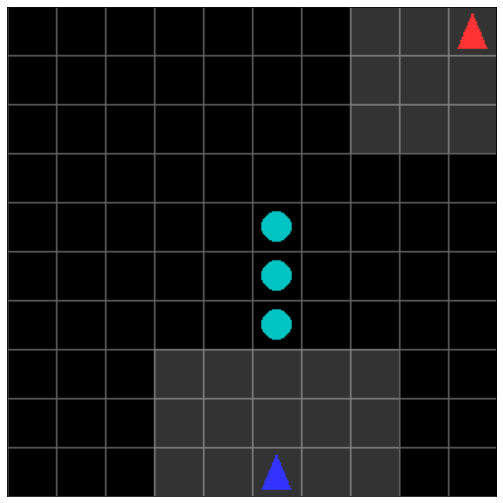

In [3]:
fig, ax = plot_utils.plot_environment(ENV_NAME, (9, 9))
fig.savefig(osp.join(figure_dir, "env.png"))
plt.show()

## Loading Heuristic Policy Data

In [4]:
policy_df = plot_utils.import_results(
    policy_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)

policy_agent_ids = policy_df["agent_id"].unique().tolist()
policy_agent_ids.sort()
print(f"Agent IDs = {policy_agent_ids}")

all_fixed_policy_ids = policy_df["policy_id"].unique().tolist()
all_fixed_policy_ids.sort()
print("\nAll Policies")
print("------------")
for pi_id in all_fixed_policy_ids:
    print("  ", pi_id)
    
# Drop unneeded co-player policies
policy_df = policy_df[policy_df["policy_id"].isin(fixed_policy_ids)]
kept_fixed_policy_ids = policy_df["policy_id"].unique().tolist()
kept_fixed_policy_ids.sort()
print("\nFixed Policies")
print("--------------")
for pi_id in kept_fixed_policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in policy_df.columns:
    print("  ", c)

Agent IDs = [0, 1]

All Policies
------------
   random-v0
   sp_seed0-v0
   sp_seed1-v0
   sp_seed2-v0
   sp_seed3-v0
   sp_seed4-v0

Fixed Policies
--------------
   sp_seed0-v0
   sp_seed1-v0
   sp_seed2-v0
   sp_seed3-v0
   sp_seed4-v0

Columns
-------
   exp_id
   agent_id
   env_id
   policy_id
   exp_seed
   num_episodes
   time_limit
   episode_return_mean
   episode_return_std
   episode_return_max
   episode_return_min
   episode_steps_mean
   episode_steps_std
   episode_time_mean
   episode_time_std
   num_episode_done
   num_LOSS
   num_DRAW
   num_WIN
   num_NA
   episode_return_CI
   episode_steps_CI
   episode_time_CI
   prop_LOSS
   prop_DRAW
   prop_WIN
   prop_NA
   num_sims
   search_time_limit
   truncated
   coplayer_policy_id


## Fixed policy pairwise performance

This is what was used to generate the meta-policies.

Here we show pairwise performance between each individual policy and co-team

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]
/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]


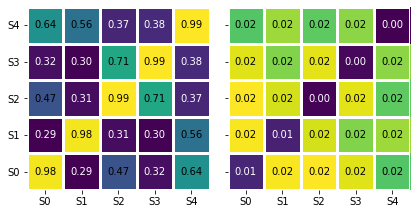

In [5]:
fig, axs = plot_utils.plot_pairwise_comparison(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    coplayer_policy_key="coplayer_policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(6, 3), 
    valfmt="{x:.2f}",
    policies=fixed_policy_ids,
    coplayer_policies=coplayer_policy_ids,
    policy_labels=fixed_policy_label_map,
    average_duplicates=True,
    duplicate_warning=False
)
fig.savefig(osp.join(figure_dir, "fixed_policy_payoffs.png"))

In [6]:
# Get payofss in meta policy dictionary format (for use in experiments)
pw_values, (row_policies, col_policies) = plot_utils.get_pairwise_values(
    policy_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    coplayer_policy_key="coplayer_policy_id",
    policies=fixed_policy_ids,
    coplayer_policies=coplayer_policy_ids,
    average_duplicates=True,
    duplicate_warning=True
)

for c, col_policy in enumerate(col_policies):
    print(f'(-1, "{col_policy}"):', "{")
    for r, row_policy in enumerate(row_policies):
        print(f'    "{row_policy}": {pw_values[r][c]:.2f},')
    print("},")

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]


(-1, "sp_seed0-v0"): {
    "sp_seed0-v0": 0.98,
    "sp_seed1-v0": 0.29,
    "sp_seed2-v0": 0.47,
    "sp_seed3-v0": 0.32,
    "sp_seed4-v0": 0.64,
},
(-1, "sp_seed1-v0"): {
    "sp_seed0-v0": 0.29,
    "sp_seed1-v0": 0.98,
    "sp_seed2-v0": 0.31,
    "sp_seed3-v0": 0.30,
    "sp_seed4-v0": 0.56,
},
(-1, "sp_seed2-v0"): {
    "sp_seed0-v0": 0.47,
    "sp_seed1-v0": 0.31,
    "sp_seed2-v0": 0.99,
    "sp_seed3-v0": 0.71,
    "sp_seed4-v0": 0.37,
},
(-1, "sp_seed3-v0"): {
    "sp_seed0-v0": 0.32,
    "sp_seed1-v0": 0.30,
    "sp_seed2-v0": 0.71,
    "sp_seed3-v0": 0.99,
    "sp_seed4-v0": 0.38,
},
(-1, "sp_seed4-v0"): {
    "sp_seed0-v0": 0.64,
    "sp_seed1-v0": 0.56,
    "sp_seed2-v0": 0.37,
    "sp_seed3-v0": 0.38,
    "sp_seed4-v0": 0.99,
},


## Add Full-Knowledge Best-Response baseline

In [7]:
# Maps from Co-Team ID to best fixed policy
best_response_map = {
    'sp_seed0-v0': 'sp_seed0-v0',
    'sp_seed1-v0': 'sp_seed1-v0',
    'sp_seed2-v0': 'sp_seed2-v0',
    'sp_seed3-v0': 'sp_seed3-v0',
    'sp_seed4-v0': 'sp_seed4-v0',
}

# use results from agent 0 so it's the same as BA-POSGMCP and other baseline results
br_agent_id = 0

new_rows = []
for co_team_id, br_policy_id in best_response_map.items():
    next_exp_id = policy_df["exp_id"].max() + 1
    
    # Add BR agent row
    br_row = policy_df.loc[
        (policy_df["agent_id"] == br_agent_id)
        & (policy_df["policy_id"] == br_policy_id) 
        & (policy_df["coplayer_policy_id"] == co_team_id)
    ].copy()
    # update policy id to baseline name
    br_row["policy_id"] = "full-knowledge-br"
    # update exp ids to avoid duplicates
    old_exp_id = br_row["exp_id"]
    br_row["exp_id"] = next_exp_id
    new_rows.append(br_row)
    
    # Add Coplayer rows from same exp_id
    for co_agent_id in policy_agent_ids:
        if co_agent_id == br_agent_id:
            continue
        br_coplayer_row = policy_df.loc[
            (policy_df["agent_id"] == co_agent_id)
            & (policy_df["exp_id"].isin(old_exp_id))
        ].copy()
        br_coplayer_row["exp_id"] = next_exp_id
        new_rows.append(br_coplayer_row)

print(f"{len(policy_df)=}")
print(f"{len(new_rows)=}")
br_df = pd.concat(new_rows, axis='rows').reset_index(drop=True)
print(f"{len(br_df)=}")
policy_br_df = pd.concat([policy_df, br_df], ignore_index=True)

print(f"{len(policy_br_df)=} (i.e. all together)")
policy_br_df[policy_br_df["policy_id"] == "full-knowledge-br"]
    

len(policy_df)=35
len(new_rows)=10
len(br_df)=10
len(policy_br_df)=45 (i.e. all together)


,exp_id,agent_id,env_id,policy_id,exp_seed,num_episodes,time_limit,episode_return_mean,episode_return_std,episode_return_max,...,episode_steps_CI,episode_time_CI,prop_LOSS,prop_DRAW,prop_WIN,prop_NA,num_sims,search_time_limit,truncated,coplayer_policy_id
35,21,0,PredatorPrey10x10-P2-p3-s2-coop-v0,full-knowledge-br,0,1000,None,0.979333,0.095543,1.0,...,0.531433,0.002710,0.0,0.0,0.947,0.053,0,NaN,False,sp_seed0-v0
37,21,0,PredatorPrey10x10-P2-p3-s2-coop-v0,full-knowledge-br,0,1000,None,0.978333,0.089923,1.0,...,0.464842,0.002911,0.0,0.0,0.941,0.059,0,NaN,False,sp_seed1-v0
39,21,0,PredatorPrey10x10-P2-p3-s2-coop-v0,full-knowledge-br,0,1000,None,0.988333,0.064786,1.0,...,0.369694,0.002524,0.0,0.0,0.967,0.033,0,NaN,False,sp_seed2-v0
41,21,0,PredatorPrey10x10-P2-p3-s2-coop-v0,full-knowledge-br,0,1000,None,0.989000,0.068241,1.0,...,0.485453,0.002314,0.0,0.0,0.971,0.029,0,NaN,False,sp_seed3-v0
43,21,0,PredatorPrey10x10-P2-p3-s2-coop-v0,full-knowledge-br,0,1000,None,0.991000,0.061708,1.0,...,0.360629,0.002220,0.0,0.0,0.977,0.023,0,NaN,False,sp_seed4-v0


## Loading BAPOSGMCP Data

In [8]:
baposgmcp_df = plot_utils.import_results(
    baposgmcp_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)
policy_ids = baposgmcp_df["policy_id"].unique().tolist()
policy_ids.sort()
print("Policies")
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in baposgmcp_df.columns:
    print("  ", f'"{c}",')

Policies
--------
   baposgmcp-fixed_pispseed0-v0_numsims1000_truncatedTrue
   baposgmcp-fixed_pispseed0-v0_numsims100_truncatedTrue
   baposgmcp-fixed_pispseed0-v0_numsims10_truncatedTrue
   baposgmcp-fixed_pispseed0-v0_numsims500_truncatedTrue
   baposgmcp-fixed_pispseed0-v0_numsims50_truncatedTrue
   baposgmcp-fixed_pispseed1-v0_numsims1000_truncatedTrue
   baposgmcp-fixed_pispseed1-v0_numsims100_truncatedTrue
   baposgmcp-fixed_pispseed1-v0_numsims10_truncatedTrue
   baposgmcp-fixed_pispseed1-v0_numsims500_truncatedTrue
   baposgmcp-fixed_pispseed1-v0_numsims50_truncatedTrue
   baposgmcp-fixed_pispseed2-v0_numsims1000_truncatedTrue
   baposgmcp-fixed_pispseed2-v0_numsims100_truncatedTrue
   baposgmcp-fixed_pispseed2-v0_numsims10_truncatedTrue
   baposgmcp-fixed_pispseed2-v0_numsims500_truncatedTrue
   baposgmcp-fixed_pispseed2-v0_numsims50_truncatedTrue
   baposgmcp-fixed_pispseed3-v0_numsims1000_truncatedTrue
   baposgmcp-fixed_pispseed3-v0_numsims100_truncatedTrue
   baposgmcp-fi

In [9]:
baposgmcp_time_df = plot_utils.import_results(
    baposgmcp_time_results_file, clean_policy_id=True, add_coplayer_policy_id=True
)

policy_ids = baposgmcp_time_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicies")
print("--------")
for pi_id in policy_ids:
    print("  ", pi_id)

print("\nColumns")
print("-------")
for c in baposgmcp_time_df.columns:
    print("  ", f'"{c}",')


Policies
--------
   baposgmcp-random_searchtimelimit0.1_truncatedFalse
   baposgmcp-random_searchtimelimit10_truncatedFalse
   baposgmcp-random_searchtimelimit1_truncatedFalse
   baposgmcp-random_searchtimelimit20_truncatedFalse
   baposgmcp-random_searchtimelimit5_truncatedFalse
   baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
   baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
   baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
   baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue
   baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue
   metabaseline_softmax
   sp_seed0-v0
   sp_seed1-v0
   sp_seed2-v0
   sp_seed3-v0
   sp_seed4-v0
   ucbmcp-random_searchtimelimit0.1_truncatedFalse
   ucbmcp-random_searchtimelimit10_truncatedFalse
   ucbmcp-random_searchtimelimit1_truncatedFalse
   ucbmcp-random_searchtimelimit20_truncatedFalse
   ucbmcp-random_searchtimelimit5_truncatedFalse
   ucbmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
   ucbmcp_metasoftmax_searchti

## Combine data

In [10]:
def combine_dfs(df1, df2):
    # First need to update exp_ids of one dataframe so there are no duplicate exp_ids
    df1_max_exp_id = df1["exp_id"].max()
    if df2["exp_id"].min() <= df1_max_exp_id:
        df2["exp_id"] += df1_max_exp_id+1

    combined_df = pd.concat([df1, df2]).reset_index(drop = True)

    def add_alg_id(row):
        pi_id = row["policy_id"]
        if pi_id.startswith("sp_"):
            return "fixed"
        tokens = pi_id.split("_")
        alg_id = "_".join([
            t for t in tokens 
            if all(
                s not in t for s in [
                    "actionselection", "numsims", "truncated", "greedy", "softmax", "uniform", "pisp", 
                    "searchtimelimit"
                ]
            )
        ])
        return alg_id


    def add_meta_pi(row):
        pi_id = row["policy_id"]
        for meta_pi in ["greedy", "softmax", "uniform"]:
            if meta_pi in pi_id:
                return meta_pi
        return "NA"


    combined_df["alg_id"] = combined_df.apply(add_alg_id, axis=1)
    combined_df["meta_pi"] = combined_df.apply(add_meta_pi, axis=1)

    policy_ids = combined_df["policy_id"].unique().tolist()
    policy_ids.sort()
    print("Policies")
    print("--------")
    for pi_id in policy_ids:
        print("  ", pi_id)

    alg_ids = combined_df["alg_id"].unique().tolist()
    alg_ids.sort()
    print("\nAlg IDs")
    print("-------")
    for n in alg_ids:
        print("  ", n)

    print("\nMeta Pis:")
    print("---------")
    print(combined_df["meta_pi"].unique().tolist())

    print("\nColumns")
    print("-------")
    for c in combined_df.columns:
        print("  ", c)
        
    return combined_df

In [11]:
baposgmcp_combined_df = combine_dfs(baposgmcp_df, policy_br_df)

Policies
--------
   baposgmcp-fixed_pispseed0-v0_numsims1000_truncatedTrue
   baposgmcp-fixed_pispseed0-v0_numsims100_truncatedTrue
   baposgmcp-fixed_pispseed0-v0_numsims10_truncatedTrue
   baposgmcp-fixed_pispseed0-v0_numsims500_truncatedTrue
   baposgmcp-fixed_pispseed0-v0_numsims50_truncatedTrue
   baposgmcp-fixed_pispseed1-v0_numsims1000_truncatedTrue
   baposgmcp-fixed_pispseed1-v0_numsims100_truncatedTrue
   baposgmcp-fixed_pispseed1-v0_numsims10_truncatedTrue
   baposgmcp-fixed_pispseed1-v0_numsims500_truncatedTrue
   baposgmcp-fixed_pispseed1-v0_numsims50_truncatedTrue
   baposgmcp-fixed_pispseed2-v0_numsims1000_truncatedTrue
   baposgmcp-fixed_pispseed2-v0_numsims100_truncatedTrue
   baposgmcp-fixed_pispseed2-v0_numsims10_truncatedTrue
   baposgmcp-fixed_pispseed2-v0_numsims500_truncatedTrue
   baposgmcp-fixed_pispseed2-v0_numsims50_truncatedTrue
   baposgmcp-fixed_pispseed3-v0_numsims1000_truncatedTrue
   baposgmcp-fixed_pispseed3-v0_numsims100_truncatedTrue
   baposgmcp-fi

In [12]:
baposgmcp_time_combined_df = combine_dfs(baposgmcp_time_df, policy_br_df)

Policies
--------
   baposgmcp-random_searchtimelimit0.1_truncatedFalse
   baposgmcp-random_searchtimelimit10_truncatedFalse
   baposgmcp-random_searchtimelimit1_truncatedFalse
   baposgmcp-random_searchtimelimit20_truncatedFalse
   baposgmcp-random_searchtimelimit5_truncatedFalse
   baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
   baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
   baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
   baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue
   baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue
   full-knowledge-br
   metabaseline_softmax
   sp_seed0-v0
   sp_seed1-v0
   sp_seed2-v0
   sp_seed3-v0
   sp_seed4-v0
   ucbmcp-random_searchtimelimit0.1_truncatedFalse
   ucbmcp-random_searchtimelimit10_truncatedFalse
   ucbmcp-random_searchtimelimit1_truncatedFalse
   ucbmcp-random_searchtimelimit20_truncatedFalse
   ucbmcp-random_searchtimelimit5_truncatedFalse
   ucbmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
   ucbmcp_

In [13]:
baposgmcp_time_combined_df["search_time_limit"].unique().tolist()

[0.1, 10.0, 1.0, 20.0, 5.0, nan]

## Pairwise performance

Here we look at the performance of each policy against each other policy including BAPOSGMCP and baselines with different number of simulations, action selection, and meta-policies.

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]
/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]


(<Figure size 1440x4608 with 2 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object))

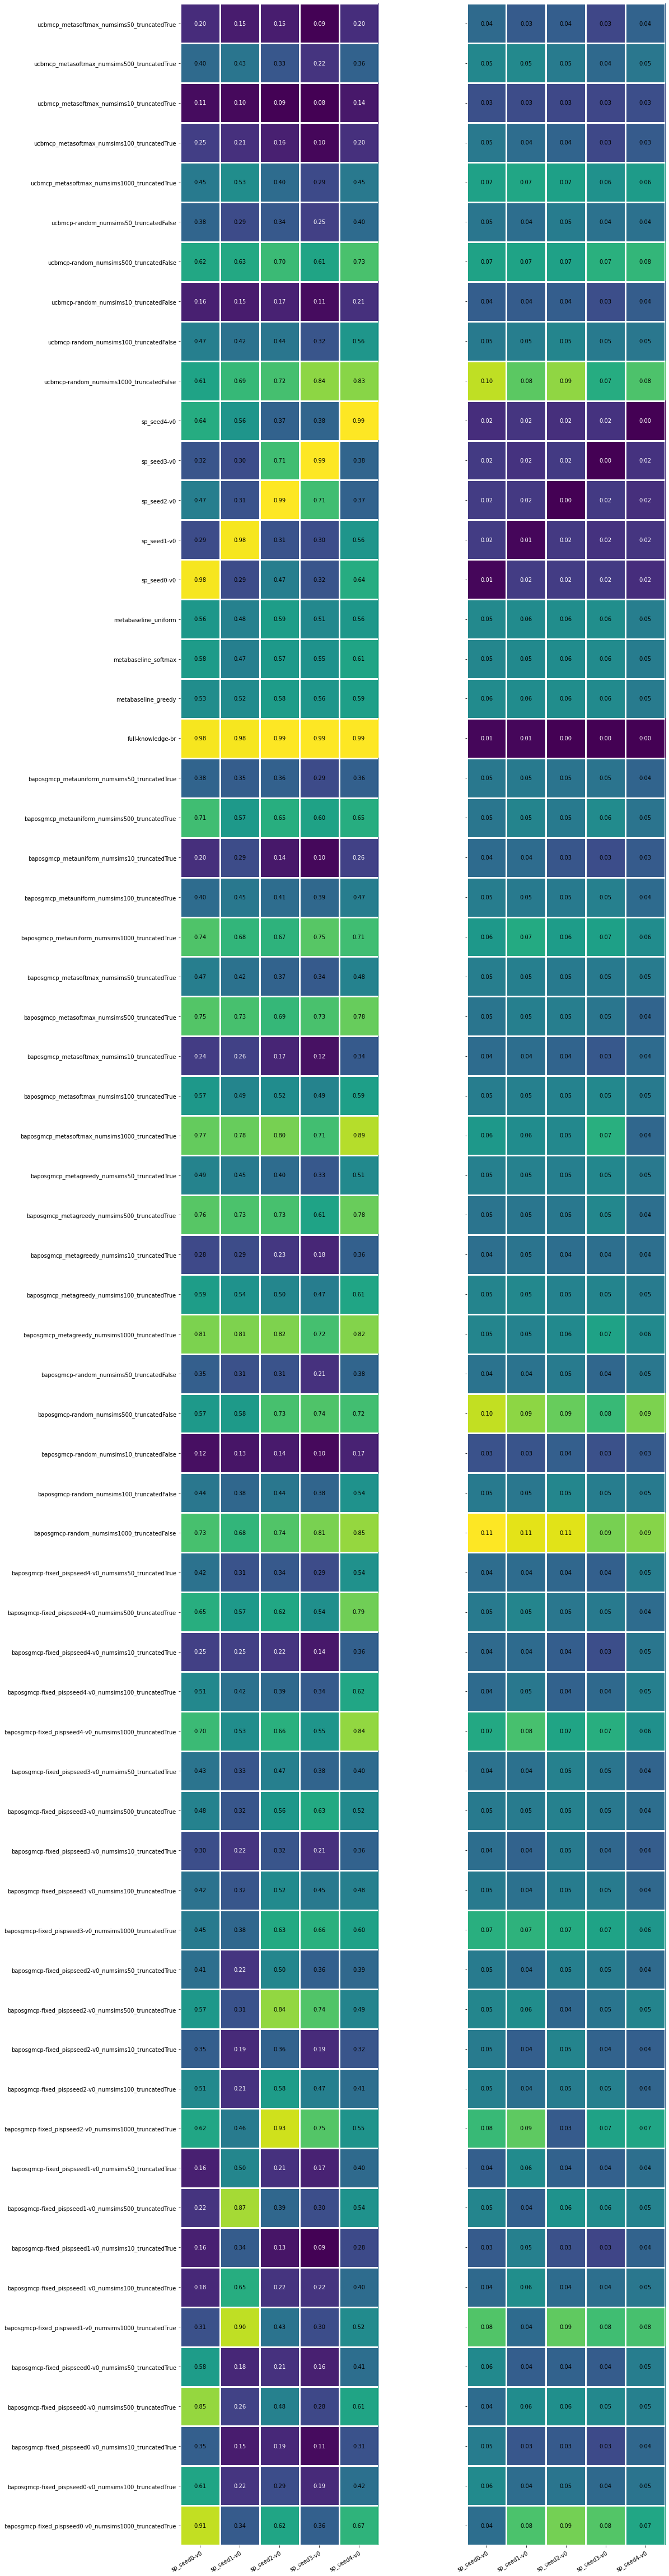

In [14]:
plot_utils.plot_pairwise_comparison(
    baposgmcp_combined_df,
    y_key="episode_return_mean", 
    policy_key="policy_id",
    y_err_key="episode_return_CI",
    vrange=None, 
    figsize=(20, len(baposgmcp_combined_df["policy_id"].unique())), 
    valfmt="{x:.2f}",
    coplayer_policies=coplayer_policy_ids,
    average_duplicates=True,
    duplicate_warning=False
)

/home/jonathon/code/ba-posgmcp/baposgmcp/plot/pairwise.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pw_values[row_policy_idx][col_policy_idx] = group.mean()[y_key]


(<Figure size 1440x4608 with 1 Axes>, array([[<AxesSubplot:>]], dtype=object))

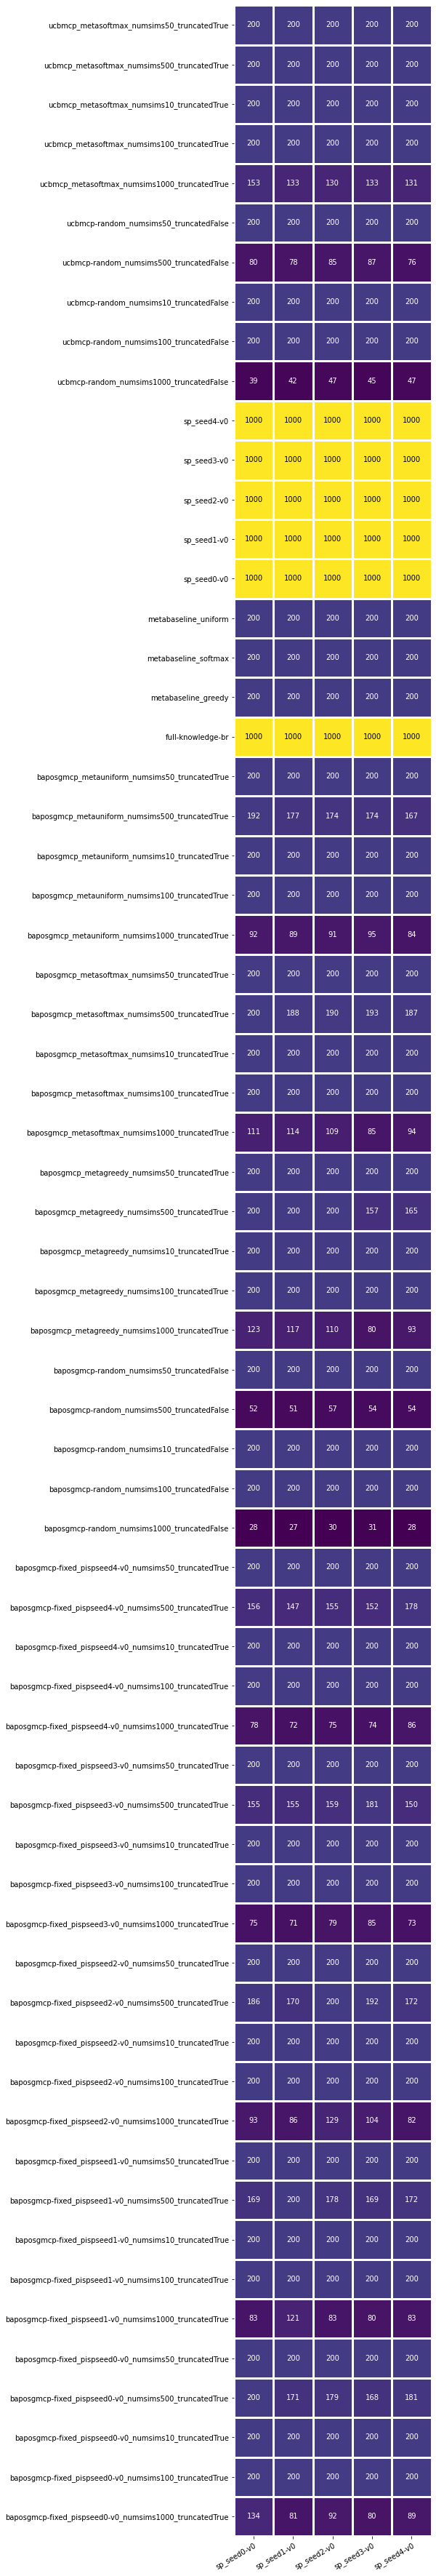

In [15]:
plot_utils.plot_pairwise_comparison(
    baposgmcp_combined_df,
    y_key="num_episodes", 
    policy_key="policy_id",
    y_err_key=None,
    vrange=None, 
    figsize=(20, len(baposgmcp_combined_df["policy_id"].unique())), 
    valfmt="{x:.0f}",
    coplayer_policies=coplayer_policy_ids,
    average_duplicates=True,
    duplicate_warning=False
)

# Expected Performance

Here we look at the expected performance given the policy prior of BAPOSGMCP and the different baselines.

Specifically:

1. Comparing different meta-policies
2. Comparing meta-policies versus using single policy
3. Comparing performance between all algorithms

In [16]:
exp_df = plot_utils.get_uniform_expected_df(
    baposgmcp_combined_df, 
    coplayer_policies=coplayer_policy_ids,
    coplayer_policy_key="coplayer_policy_id"
)
exp_df.to_csv(osp.join(BASE_RESULTS_DIR, "sims_expected_performance_results.csv"))

Ungrouped size = 330
Grouped size = 64


In [17]:
time_exp_df = plot_utils.get_uniform_expected_df(
    baposgmcp_time_combined_df, 
    coplayer_policies=coplayer_policy_ids,
    coplayer_policy_key="coplayer_policy_id"
)
time_exp_df.to_csv(osp.join(BASE_RESULTS_DIR, "time_expected_performance_results.csv"))

Ungrouped size = 145
Grouped size = 27


In [18]:
# Base plot kwargs
base_plot_kwargs = paper_utils.get_base_plot_kwargs()
return_plot_kwargs = copy.deepcopy(base_plot_kwargs)
return_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Return",
})

step_plot_kwargs = copy.deepcopy(return_plot_kwargs)
step_plot_kwargs["subplot_kwargs"].update({
    "ylabel": "Mean Episode Steps"
})

## Comparison of the different Meta-Policies

Here we look at the performance of our algorithm using the difference meta-policies.

Looking at performance with:

- truncated search
- using PUCB

We also look at the performance of the metabaseline with the different meta-policies.

In [19]:
meta_pi_label_map = {
    "greedy": r"$\sigma^{G}$",
    "softmax": r"$\sigma^{S}$",
    "uniform": r"$\sigma^{U}$",
}

meta_pi_df = exp_df[
    (exp_df["action_selection"].isin(["pucb", None]))
    & (
        (exp_df["alg_id"].isin(["metabaseline"]))
        | (
            (exp_df["alg_id"].isin(["baposgmcp"])) & (exp_df["truncated"] == True)
        )
    )
]

meta_alg_ids = meta_pi_df["alg_id"].unique().tolist()
meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_alg_ids:
    print(n)
    
policy_ids = meta_pi_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
metabaseline

Policy IDs
----------
baposgmcp_metagreedy_numsims1000_truncatedTrue
baposgmcp_metagreedy_numsims100_truncatedTrue
baposgmcp_metagreedy_numsims10_truncatedTrue
baposgmcp_metagreedy_numsims500_truncatedTrue
baposgmcp_metagreedy_numsims50_truncatedTrue
baposgmcp_metasoftmax_numsims1000_truncatedTrue
baposgmcp_metasoftmax_numsims100_truncatedTrue
baposgmcp_metasoftmax_numsims10_truncatedTrue
baposgmcp_metasoftmax_numsims500_truncatedTrue
baposgmcp_metasoftmax_numsims50_truncatedTrue
baposgmcp_metauniform_numsims1000_truncatedTrue
baposgmcp_metauniform_numsims100_truncatedTrue
baposgmcp_metauniform_numsims10_truncatedTrue
baposgmcp_metauniform_numsims500_truncatedTrue
baposgmcp_metauniform_numsims50_truncatedTrue
metabaseline_greedy
metabaseline_softmax
metabaseline_uniform


baposgmcp
metabaseline


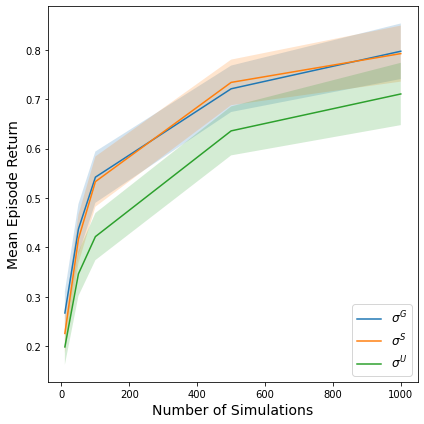

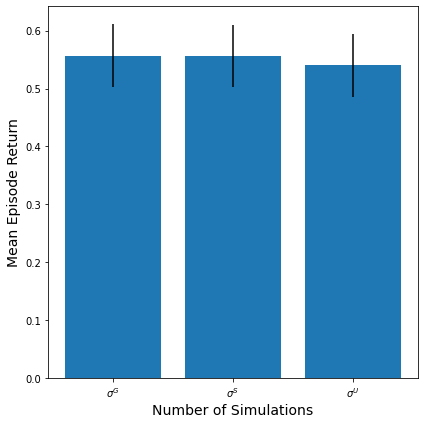

In [20]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    # "ylim": (0.15, 0.9),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Meta-Policy" 
})

for alg_id in meta_alg_ids:
    print(alg_id)
    fig, _ = plot_utils.paper.plot_multiple_meta_policy_vs_num_sims(
        meta_pi_df[meta_pi_df["alg_id"] == alg_id],
        y_key="episode_return_mean",
        y_err_key="episode_return_CI",
        meta_pi_label_map=meta_pi_label_map,
        alg_id_key="alg_id",
        set_title=False,
        **plot_kwargs
    )
    fig.tight_layout()
    fig.savefig(osp.join(figure_dir, f"meta_pi_return_{alg_id}.png"))
    
del plot_kwargs

## Comparing Meta-Policy versus no meta-policy

Here we look at the performance of BAPOSGMCP (using PUCB) with using a meta-policy against not using a meta-policy (i.e. using the different fixed policies).

In [21]:
meta_vs_no_pi_label_map = {
    "baposgmcp_metasoftmax": r"$\sigma^{S}$",
    "baposgmcp-random": "Random",
    "baposgmcp-fixed_pispseed0-v0": "S0",
    "baposgmcp-fixed_pispseed1-v0": "S1",
    "baposgmcp-fixed_pispseed2-v0": "S2",
    "baposgmcp-fixed_pispseed3-v0": "S3",
    "baposgmcp-fixed_pispseed4-v0": "S4",
}

# Use DF containing only policies with PUCB action_selection or NA
meta_vs_no_meta_df = exp_df[
    (exp_df["alg_id"].isin(["baposgmcp", "baposgmcp-fixed", "baposgmcp-random"]))
    & (exp_df["meta_pi"].isin(["softmax", "NA"]))
]

meta_vs_no_meta_alg_ids = meta_vs_no_meta_df["alg_id"].unique().tolist()
meta_vs_no_meta_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in meta_vs_no_meta_alg_ids:
    print(n)
    
policy_ids = meta_vs_no_meta_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)
    
fixed_policy_ids = meta_vs_no_meta_df["fixed_policy_id"].unique().tolist()
print("\nFixed Policy IDs")
print("----------------")
for n in fixed_policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
baposgmcp-fixed
baposgmcp-random

Policy IDs
----------
baposgmcp-fixed_pispseed0-v0_numsims1000_truncatedTrue
baposgmcp-fixed_pispseed0-v0_numsims100_truncatedTrue
baposgmcp-fixed_pispseed0-v0_numsims10_truncatedTrue
baposgmcp-fixed_pispseed0-v0_numsims500_truncatedTrue
baposgmcp-fixed_pispseed0-v0_numsims50_truncatedTrue
baposgmcp-fixed_pispseed1-v0_numsims1000_truncatedTrue
baposgmcp-fixed_pispseed1-v0_numsims100_truncatedTrue
baposgmcp-fixed_pispseed1-v0_numsims10_truncatedTrue
baposgmcp-fixed_pispseed1-v0_numsims500_truncatedTrue
baposgmcp-fixed_pispseed1-v0_numsims50_truncatedTrue
baposgmcp-fixed_pispseed2-v0_numsims1000_truncatedTrue
baposgmcp-fixed_pispseed2-v0_numsims100_truncatedTrue
baposgmcp-fixed_pispseed2-v0_numsims10_truncatedTrue
baposgmcp-fixed_pispseed2-v0_numsims500_truncatedTrue
baposgmcp-fixed_pispseed2-v0_numsims50_truncatedTrue
baposgmcp-fixed_pispseed3-v0_numsims1000_truncatedTrue
baposgmcp-fixed_pispseed3-v0_numsims100_truncatedTrue
ba

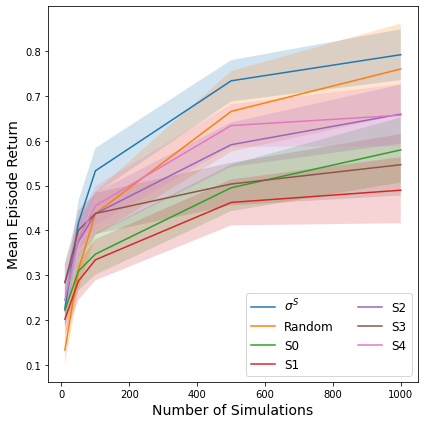

In [23]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    # "ylim": (0.1, 0.85),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Policy",
    "ncol": 2
})

fig, _ = plot_utils.paper.plot_multiple_performance(
    meta_vs_no_meta_df,
    x_key="num_sims",
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[list(meta_vs_no_pi_label_map)],
    pi_label_map=meta_vs_no_pi_label_map,
    constant_policy_prefixes=[],
    **plot_kwargs,
)

fig.tight_layout()
fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_return.png"))
    
del plot_kwargs

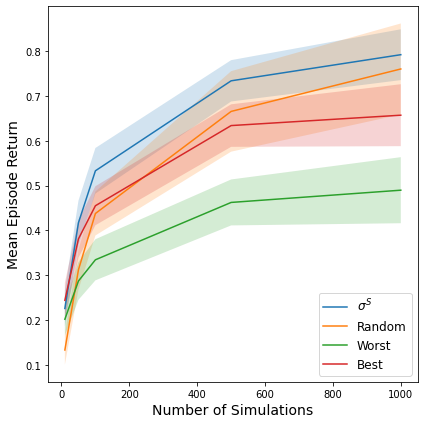

In [24]:
meta_vs_no_best_and_worst_pi_label_map = {
    "baposgmcp_metasoftmax": r"$\sigma^{S}$",
    "baposgmcp-random": "Random",
    # "baposgmcp_fixed_pispseed0-v0": "S0",
    "baposgmcp-fixed_pispseed1-v0": "Worst",
    # "baposgmcp_fixed_pispseed2-v0": "S2",
    # "baposgmcp_fixed_pispseed3-v0": "S3",
    "baposgmcp-fixed_pispseed4-v0": "Best",
}

plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    # "ylim": (0.1, 0.85),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
    # "title": "Policy",
    "ncol": 1
})

fig, _ = plot_utils.paper.plot_multiple_performance(
    meta_vs_no_meta_df,
    x_key="num_sims",
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[list(meta_vs_no_best_and_worst_pi_label_map)],
    pi_label_map=meta_vs_no_best_and_worst_pi_label_map,
    constant_policy_prefixes=[],
    **plot_kwargs,
)

fig.tight_layout()
fig.savefig(osp.join(figure_dir, f"meta_vs_fixed_return_best_and_worst.png"))
    
del plot_kwargs

## Comparing BAPOSGMCP versus baselines

Finally we compare BAPOSGMCP versus baselines. Specifically we compare:

- BAPOSGMCP (PUCB + Best Meta)
- IPOMCP-Meta (UCB + Best Meta)
- IPOMCP (UCB + Random)
- Full Knowledge BR
- Meta

In [25]:
best_meta_pi = "softmax"
perf_df = exp_df[
    (exp_df["alg_id"] == "full-knowledge-br")
    | ((exp_df["alg_id"] == "metabaseline") & (exp_df["meta_pi"] == best_meta_pi))
    | ((exp_df["alg_id"] == "baposgmcp") & (exp_df["meta_pi"] == best_meta_pi) & (exp_df["truncated"] == True))
    | ((exp_df["alg_id"] == "baposgmcp-random") & (exp_df["truncated"] == False))
    | ((exp_df["alg_id"] == "ucbmcp") & (exp_df["meta_pi"] == best_meta_pi) & (exp_df["truncated"] == True))
    | ((exp_df["alg_id"] == "ucbmcp-random") & (exp_df["truncated"] == False))
]

policy_prefixes_to_plot = [
    f"baposgmcp_meta{best_meta_pi}",
    # "baposgmcp-random",
    "ucbmcp-random",
    f"ucbmcp_meta{best_meta_pi}",
    f"metabaseline_{best_meta_pi}",
    f"full-knowledge-br",
]

constant_policy_prefixes=[
    f"metabaseline_{best_meta_pi}",
    f"full-knowledge-br",
]

baseline_pi_label_map = {
    f"baposgmcp_meta{best_meta_pi}": algname,
    # "baposgmcp-random": f"{algname} + Random", 
    "full-knowledge-br": "Best-Response",
    f"metabaseline_{best_meta_pi}": "Meta-Policy",
    f"ucbmcp_meta{best_meta_pi}": f"{baselinealgname} + Meta",
    "ucbmcp-random": f"{baselinealgname} + Random"
}

perf_ids = perf_df["alg_id"].unique().tolist()
perf_ids.sort()
print("Alg IDs")
print("-------")
for n in perf_ids:
    print(n)
    
policy_ids = perf_df["policy_id"].unique().tolist()
policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
baposgmcp-random
full-knowledge-br
metabaseline
ucbmcp
ucbmcp-random

Policy IDs
----------
baposgmcp-random_numsims1000_truncatedFalse
baposgmcp-random_numsims100_truncatedFalse
baposgmcp-random_numsims10_truncatedFalse
baposgmcp-random_numsims500_truncatedFalse
baposgmcp-random_numsims50_truncatedFalse
baposgmcp_metasoftmax_numsims1000_truncatedTrue
baposgmcp_metasoftmax_numsims100_truncatedTrue
baposgmcp_metasoftmax_numsims10_truncatedTrue
baposgmcp_metasoftmax_numsims500_truncatedTrue
baposgmcp_metasoftmax_numsims50_truncatedTrue
full-knowledge-br
metabaseline_softmax
ucbmcp-random_numsims1000_truncatedFalse
ucbmcp-random_numsims100_truncatedFalse
ucbmcp-random_numsims10_truncatedFalse
ucbmcp-random_numsims500_truncatedFalse
ucbmcp-random_numsims50_truncatedFalse
ucbmcp_metasoftmax_numsims1000_truncatedTrue
ucbmcp_metasoftmax_numsims100_truncatedTrue
ucbmcp_metasoftmax_numsims10_truncatedTrue
ucbmcp_metasoftmax_numsims500_truncatedTrue
ucbmcp_metasoftmax_n

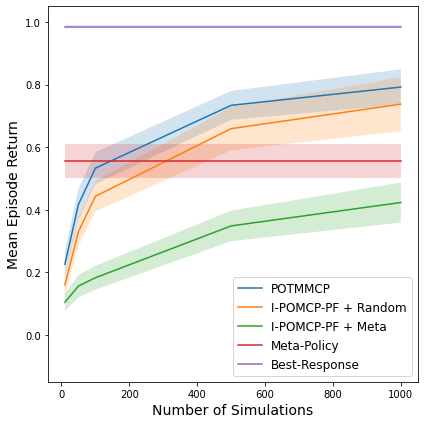

In [26]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "ylim": (-0.15, 1.05),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
})
plot_kwargs["fig_kwargs"].update({
    "figsize": (6, 6),
})

fig, _ = plot_utils.paper.plot_multiple_performance(
    perf_df,
    x_key="num_sims",
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[policy_prefixes_to_plot],
    pi_label_map=baseline_pi_label_map,
    constant_policy_prefixes=constant_policy_prefixes,
    **plot_kwargs,
)

fig.tight_layout()
fig.savefig(osp.join(figure_dir, "baselines_return.png"))
    
del plot_kwargs

## Performance vs search time

In [27]:
best_meta_pi = "softmax"
time_perf_df = time_exp_df[
    (time_exp_df["alg_id"] == "full-knowledge-br")
    | ((time_exp_df["alg_id"] == "metabaseline") & (time_exp_df["meta_pi"] == best_meta_pi))
    | ((time_exp_df["alg_id"] == "baposgmcp") & (time_exp_df["meta_pi"] == best_meta_pi) & (time_exp_df["truncated"] == True))
    | ((time_exp_df["alg_id"] == "baposgmcp-random") & (time_exp_df["truncated"] == False))
    | ((time_exp_df["alg_id"] == "ucbmcp") & (time_exp_df["meta_pi"] == best_meta_pi) & (time_exp_df["truncated"] == True))
    | ((time_exp_df["alg_id"] == "ucbmcp-random") & (time_exp_df["truncated"] == False))
]

time_baseline_policy_prefixes_to_plot = [
    f"baposgmcp_meta{best_meta_pi}",
    # "baposgmcp-random",
    "ucbmcp-random",
    f"ucbmcp_meta{best_meta_pi}",
    f"metabaseline_{best_meta_pi}",
    f"full-knowledge-br",
]

time_baseline_pi_label_map = {
    f"baposgmcp_meta{best_meta_pi}": algname,
    # "baposgmcp-random": f"{algname} + Random", 
    "full-knowledge-br": "Best-Response",
    f"metabaseline_{best_meta_pi}": "Meta-Policy",
    f"ucbmcp_meta{best_meta_pi}": f"{baselinealgname} + Meta",
    "ucbmcp-random": f"{baselinealgname} + Random"
}

time_perf_ids = time_perf_df["alg_id"].unique().tolist()
time_perf_ids.sort()
print("Alg IDs")
print("-------")
for n in time_perf_ids:
    print(n)
    
time_policy_ids = time_perf_df["policy_id"].unique().tolist()
time_policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in time_policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
baposgmcp-random
full-knowledge-br
metabaseline
ucbmcp
ucbmcp-random

Policy IDs
----------
baposgmcp-random_searchtimelimit0.1_truncatedFalse
baposgmcp-random_searchtimelimit10_truncatedFalse
baposgmcp-random_searchtimelimit1_truncatedFalse
baposgmcp-random_searchtimelimit20_truncatedFalse
baposgmcp-random_searchtimelimit5_truncatedFalse
baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue
full-knowledge-br
metabaseline_softmax
ucbmcp-random_searchtimelimit0.1_truncatedFalse
ucbmcp-random_searchtimelimit10_truncatedFalse
ucbmcp-random_searchtimelimit1_truncatedFalse
ucbmcp-random_searchtimelimit20_truncatedFalse
ucbmcp-random_searchtimelimit5_truncatedFalse
ucbmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
ucbmcp_metasoftmax_searchtimelimit10_tr

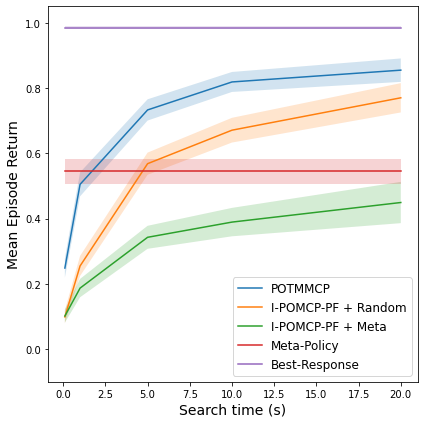

In [29]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "xlabel": "Search time (s)",
    # "xlim": (-0.2, 20),
    "ylim": (-0.1, 1.05),
})
plot_kwargs["legend_kwargs"].update({
    "loc": "lower right",
})
plot_kwargs["fig_kwargs"].update({
    "figsize": (6, 6),
})

fig, _ = plot_utils.paper.plot_multiple_performance(
    time_perf_df,
    x_key="search_time_limit",
    y_key="episode_return_mean",
    y_err_key="episode_return_CI",
    policy_prefixes=[time_baseline_policy_prefixes_to_plot],
    pi_label_map=time_baseline_pi_label_map,
    constant_policy_prefixes=constant_policy_prefixes,
    **plot_kwargs,
)

fig.tight_layout()
fig.savefig(osp.join(figure_dir, "baselines_return_vs_search_time.png"))
    
del plot_kwargs

# Analysis

Here we take a deeper dive into the characteristics of BA-POSGMCP. Specifically looking at:

1. Belief accuracy
2. Planning time


## Looking at Belief accuracy by steps

- action_dist_distance
- bayes_accuracy

In [30]:
belief_df = time_exp_df[
    (time_exp_df["alg_id"] == "baposgmcp") 
    & (time_exp_df["truncated"] == True)
    & (time_exp_df["action_selection"] == "pucb")
]

belief_alg_ids = belief_df["alg_id"].unique().tolist()
belief_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in belief_alg_ids:
    print(n)

# group over meta-policy values
belief_group_keys = ["alg_id", "search_time_limit"]
belief_agg_dict = plot_utils.get_uniform_expected_agg_map(exp_df)
belief_df_cols = set(belief_df.columns)
keys_to_drop = []
for k in belief_agg_dict:
    if k not in belief_df_cols or k in belief_group_keys:
        keys_to_drop.append(k)

for k in keys_to_drop:
    belief_agg_dict.pop(k)        
    
gb = belief_df.groupby(belief_group_keys)
gb_agg = gb.agg(**belief_agg_dict)
belief_gb_df = gb_agg.reset_index()

belief_gb_df.sort_values(by=["search_time_limit"], inplace=True)

print("Ungrouped size =", len(belief_df))
print("Grouped size =", len(belief_gb_df))
# print(belief_gb_df)

Alg IDs
-------
baposgmcp
Ungrouped size = 5
Grouped size = 5


In [31]:
belief_plot_kwargs = copy.deepcopy(base_plot_kwargs)
belief_plot_kwargs["subplot_kwargs"].update({
    "xlabel": "Step",
})
belief_plot_kwargs["legend_kwargs"].update({
    "loc": "upper left",
    # "title": "Num. Sims." 
})

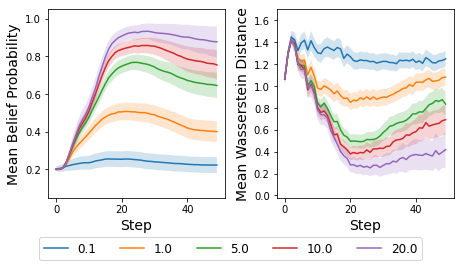

In [70]:
fig_kwargs = {"figsize": (plot_utils.paper.PAGE_COL_WIDTH*2, 3.7)}
subplot_kwargs = {
    "xlabel": "Step"
}

num_rows = 1
num_cols = 2
fig, axs = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    squeeze=True,
    subplot_kw=subplot_kwargs,
    **fig_kwargs,
)

y_lims = [(0.05, 1.05), (-0.02, 1.7)]
y_labels = ["Mean Belief Probability", "Mean Wasserstein Distance"]

plot_utils.paper.plot_expected_belief_stat_by_step(
    belief_gb_df,
    axs[0],
    z_key="search_time_limit",
    y_key_prefix="bayes_accuracy",
    step_limit=50,
    other_agent_id=1,
    y_suffix="mean",
    y_err_suffix="CI",
)
axs[0].set_ylabel(y_labels[0])
axs[0].set_ylim(y_lims[0])

plot_utils.paper.plot_expected_belief_stat_by_step(
    belief_gb_df,
    axs[1],
    z_key="search_time_limit",
    y_key_prefix="action_dist_distance",
    step_limit=50,
    other_agent_id=1,
    y_suffix="mean",
    y_err_suffix="CI",
)
axs[1].set_ylabel(y_labels[1])
axs[1].set_ylim(y_lims[1])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=5, loc="lower center")

fig.tight_layout(rect=(0.0, 0.08, 1.0, 1.0))
fig.savefig(osp.join(figure_dir, f"bayes_accuracy.png"))
    
del fig_kwargs
del subplot_kwargs

## Looking at time

   - search_time
   - update_time
   - reinvigoration_time
   - policy_calls
   - inference_time
   - search_depth

In [71]:
best_meta_pi = "softmax"
search_time_df = time_exp_df[
    ((time_exp_df["alg_id"] == "baposgmcp") & (time_exp_df["meta_pi"] == best_meta_pi) & (time_exp_df["truncated"] == True))
    | ((time_exp_df["alg_id"] == "ucbmcp") & (time_exp_df["meta_pi"] == best_meta_pi) & (time_exp_df["truncated"] == True))
    | ((time_exp_df["alg_id"] == "ucbmcp-random") & (time_exp_df["truncated"] == False))
]

policy_prefixes_to_plot = [
    f"baposgmcp_meta{best_meta_pi}",
    "ucbmcp-random",
    f"ucbmcp_meta{best_meta_pi}"
]

baseline_pi_label_map = {
    f"baposgmcp_meta{best_meta_pi}": algname,
    f"ucbmcp_meta{best_meta_pi}": f"{baselinealgname} + Meta",
    "ucbmcp-random": f"{baselinealgname} + Random"
}


times_alg_ids = search_time_df["alg_id"].unique().tolist()
times_alg_ids.sort()
print("Alg IDs")
print("-------")
for n in times_alg_ids:
    print(n)
    
times_policy_ids = search_time_df["policy_id"].unique().tolist()
times_policy_ids.sort()
print("\nPolicy IDs")
print("----------")
for n in times_policy_ids:
    print(n)

Alg IDs
-------
baposgmcp
ucbmcp
ucbmcp-random

Policy IDs
----------
baposgmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit10_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit1_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit20_truncatedTrue
baposgmcp_metasoftmax_searchtimelimit5_truncatedTrue
ucbmcp-random_searchtimelimit0.1_truncatedFalse
ucbmcp-random_searchtimelimit10_truncatedFalse
ucbmcp-random_searchtimelimit1_truncatedFalse
ucbmcp-random_searchtimelimit20_truncatedFalse
ucbmcp-random_searchtimelimit5_truncatedFalse
ucbmcp_metasoftmax_searchtimelimit0.1_truncatedTrue
ucbmcp_metasoftmax_searchtimelimit10_truncatedTrue
ucbmcp_metasoftmax_searchtimelimit1_truncatedTrue
ucbmcp_metasoftmax_searchtimelimit20_truncatedTrue
ucbmcp_metasoftmax_searchtimelimit5_truncatedTrue


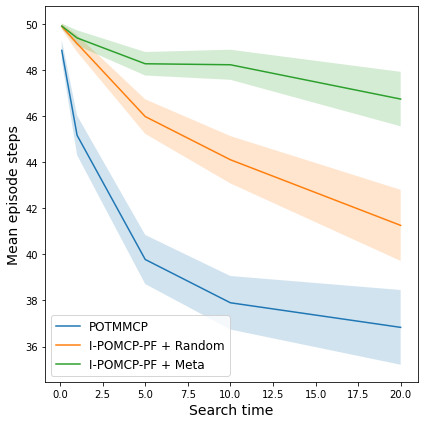

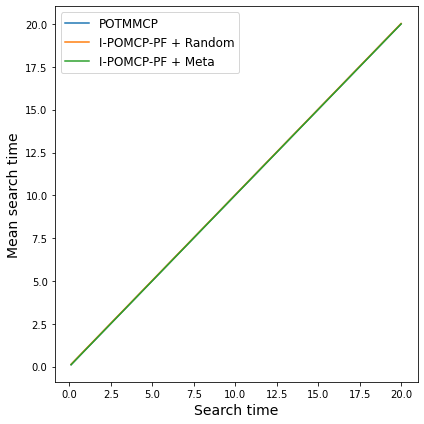

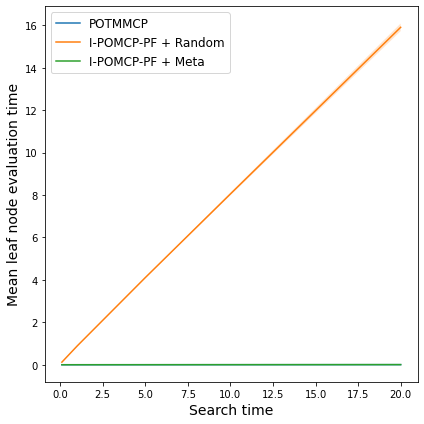

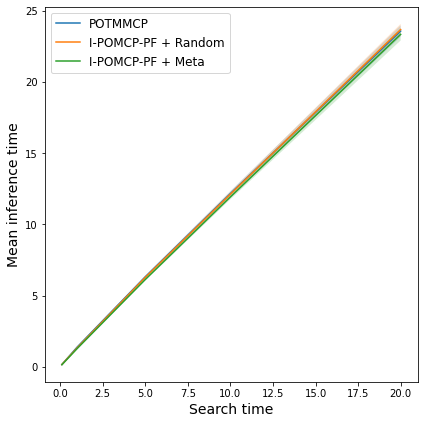

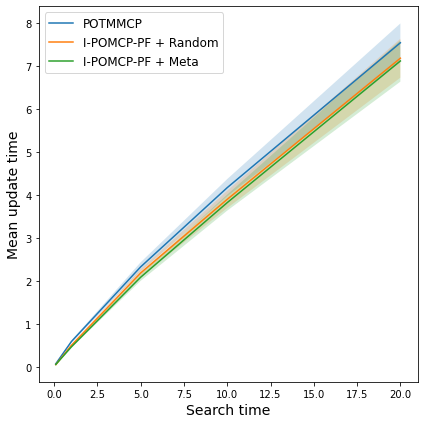

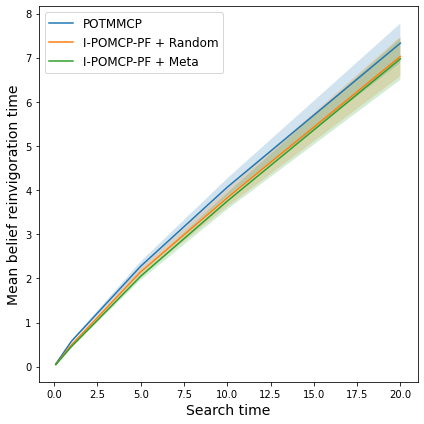

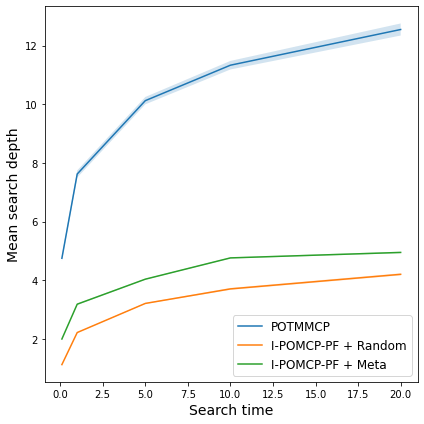

In [72]:
plot_kwargs = copy.deepcopy(return_plot_kwargs)
plot_kwargs["subplot_kwargs"].update({
    "xlabel": "Search time"
})
plot_kwargs["legend_kwargs"].update({
    # "loc": 'upper left',
})

for (y_key, y_label) in [
    ("episode_steps", "Mean episode steps"),
    ("search_time", "Mean search time"),
    ("evaluation_time", "Mean leaf node evaluation time"),
    ("inference_time", "Mean inference time"),
    ("update_time", "Mean update time"),
    ("reinvigoration_time", "Mean belief reinvigoration time"),
    ("search_depth", "Mean search depth")
]:
    plot_kwargs["subplot_kwargs"].update({
        "ylabel": y_label,
    })
    
    fig, _ = plot_utils.paper.plot_multiple_performance(
        search_time_df,
        x_key="search_time_limit",
        y_key=f"{y_key}_mean",
        y_err_key=f"{y_key}_CI",
        policy_prefixes=[policy_prefixes_to_plot],
        pi_label_map=baseline_pi_label_map,
        constant_policy_prefixes=[],
        **plot_kwargs,
    )

    fig.tight_layout()
    fig.savefig(osp.join(figure_dir, f"{y_key}.png"))
    
del plot_kwargs